In [10]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [14]:
data_dir = "archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [17]:
# Define paths based on your dataset
train_dir = "archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
test_dir = "archive/test"

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,       # Random rotation
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shear transformation
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    fill_mode='nearest'      # Fill missing pixels
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

test_data = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,  # Shuffle off for evaluation and predictions
)



Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 33 images belonging to 1 classes.


In [22]:
diseases = os.listdir(train_dir)
print(diseases)

['Strawberry___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Blueberry___healthy', 'Corn_(maize)___healthy', 'Tomato___Target_Spot', '.DS_Store', 'Peach___healthy', 'Potato___Late_blight', 'Tomato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Pepper,_bell___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Leaf_Mold', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Cherry_(including_sour)___Powdery_mildew', 'Apple___Cedar_apple_rust', 'Tomato___Bacterial_spot', 'Grape___healthy', 'Tomato___Early_blight', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___healthy', 'Cherry_(including_sour)___healthy', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Apple___Apple_scab', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Peach___Bacterial_spot', 'Pepper,_bell___Bacterial_spot', 'Tomato___Septoria_leaf_spot', 'Squash___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot

In [23]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 39


In [33]:
# Load the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
    layer.trainable = True

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),  # Increased neurons for better feature extraction
    Dropout(0.5),                   # Higher dropout rate to reduce overfitting
    Dense(train_data.num_classes, activation='softmax')
])

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,595,686 (9.90 MB)

 Trainable params: 2,561,574 (9.77 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [34]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when a metric has stopped improving
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3, 
    verbose=1,
    min_lr=1e-6
)


In [35]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, 
    restore_best_weights=True, 
    verbose=1
)

In [36]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=3,                # Train for more epochs to allow fine-tuning
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)


Epoch 1/3
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2783s 1s/step - accuracy: 0.7295 - loss: 1.0033 - val_accuracy: 0.8327 - val_loss: 0.7045 - learning_rate: 1.0000e-04
Epoch 2/3
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2732s 1s/step - accuracy: 0.9678 - loss: 0.1018 - val_accuracy: 0.9713 - val_loss: 0.0931 - learning_rate: 1.0000e-04
Epoch 3/3
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2806s 1s/step - accuracy: 0.9785 - loss: 0.0682 - val_accuracy: 0.9726 - val_loss: 0.0944 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.


In [37]:
loss, accuracy = model.evaluate(valid_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

550/550 ━━━━━━━━━━━━━━━━━━━━ 96s 174ms/step - accuracy: 0.9694 - loss: 0.0986
Test Accuracy: 97.13%


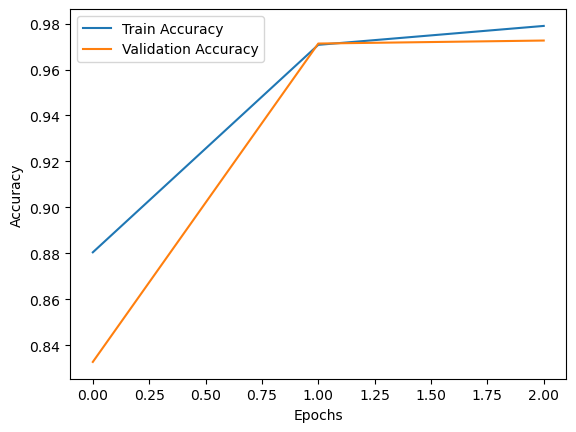

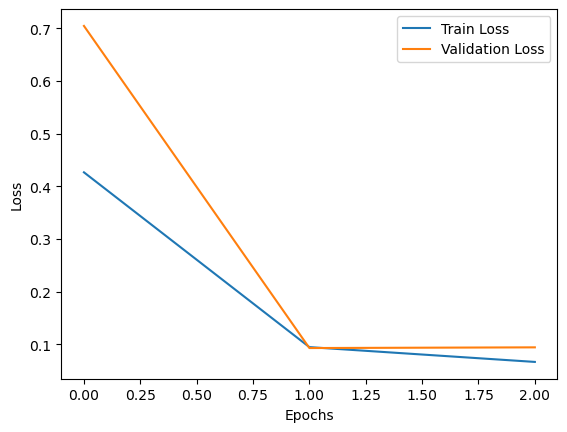

In [38]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [42]:
import numpy as np

# Get the class labels
class_labels = list(train_data.class_indices.keys())

# Predict for all images in the test data
test_data.reset()  # Reset the generator to start from the beginning
predictions = model.predict(test_data, verbose=1)  # Predict on all test images

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get the actual class indices from the test data
actual_classes = test_data.classes

# Mapping predicted indices to class labels
predicted_labels = [class_labels[idx] for idx in predicted_classes]
actual_labels = [class_labels[idx] for idx in actual_classes]

# Display some predictions along with actual labels
print("Predictions on Test Data:")
for i in range(len(predicted_labels)):
    print(f"Image {i+1}: Predicted - {predicted_labels[i]}, Actual - {actual_labels[i]}")

# Optionally, calculate accuracy on the test set
accuracy = np.sum(np.array(predicted_classes) == np.array(actual_classes)) / len(actual_classes)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
Predictions on Test Data:
Image 1: Predicted - Apple___Cedar_apple_rust, Actual - Apple___Apple_scab
Image 2: Predicted - Apple___Cedar_apple_rust, Actual - Apple___Apple_scab
Image 3: Predicted - Apple___Cedar_apple_rust, Actual - Apple___Apple_scab
Image 4: Predicted - Apple___Cedar_apple_rust, Actual - Apple___Apple_scab
Image 5: Predicted - Apple___Apple_scab, Actual - Apple___Apple_scab
Image 6: Predicted - Apple___Apple_scab, Actual - Apple___Apple_scab
Image 7: Predicted - Apple___Apple_scab, Actual - Apple___Apple_scab
Image 8: Predicted - Corn_(maize)___Common_rust_, Actual - Apple___Apple_scab
Image 9: Predicted - Corn_(maize)___Common_rust_, Actual - Apple___Apple_scab
Image 10: Predicted - Corn_(maize)___Common_rust_, Actual - Apple___Apple_scab
Image 11: Predicted - Potato___Early_blight, Actual - Apple___Apple_scab
Image 12: Predicted - Potato___Early_blight, Actual - Apple___Apple_scab
Image 13: Predicted - Potato___Early_blight, Ac

In [40]:
model.save("plant_disease_model.keras")